# Using IBM watsonx.governance metrics toolkit to evaluate the quality of your Prompt Template

- Prompt is generated against Azure OpenAI GPT-35 Turbo Deployment
- Prompt output is evaluated using OpenScale LLM SDK
- Evaluated metrics are published to OpenPages

In [ ]:
!pip install --upgrade ibm-watson-openscale --no-cache | tail -n 1
!pip install --upgrade ibm-metrics-plugin[generative_ai_quality] --no-cache | tail -n 1

In [ ]:
import nltk
nltk.download('wordnet')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Provision services and configure credentials

If you have not already, provision an instance of IBM Watson OpenScale using the [OpenScale link in the Cloud catalog](https://cloud.ibm.com/catalog/services/watson-openscale).

Your Cloud API key can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below.

**NOTE:** You can also get OpenScale `API_KEY` using IBM CLOUD CLI.

How to install IBM Cloud (bluemix) console: [instruction](https://console.bluemix.net/docs/cli/reference/ibmcloud/download_cli.html#install_use)

How to get api key using console:
```
bx login --sso
bx iam api-key-create 'my_key'
```

In [ ]:
use_cpd = False
CLOUD_API_KEY = "<Replace with your IBM Cloud API Key>"
IAM_URL="https://iam.ng.bluemix.net/oidc/token"

Uncomment the code and run the below cell only if you are running your notebook on a CPD cluster.

In [ ]:
# use_cpd = True
# WOS_CREDENTIALS = {
#     "url": "xxxxx",
#     "username": "xxxxx",
#     "api_key": "xxxxx"
# }

## Test data containing the summarization output from model and the reference data

In [ ]:
!rm -fr llm_content.csv
!wget "https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/watsonx/llm_content.csv"

In [ ]:
import pandas as pd
import numpy as np
llm_data_all = pd.read_csv("llm_content.csv")
llm_data_all.head()

In [ ]:
llm_data = llm_data_all.head(10)
llm_data.head()

# Azure OpenAI related

In [ ]:
import os
import openai

## Get the Azure OpenAI deployment details from Azure OpenAI Studio

In [ ]:
openai.api_type = "azure"
openai.api_base = "<Replace with Azure OpenAI API Base URL>"
openai.api_version = "<Replace with Azure OpenAI API Version>"
openai.api_key = '<Replace with Azure OpenAI API Key>'

In [ ]:
def get_prompt(text):
    prompt = f"""Please provide a summary of the following text with maximum of 20 words.
    
{text}
    
Summary:"""
    return prompt

## Run the prompt evaluation

In [ ]:
# Replace with the prompt config values, as needed
def get_completion(prompt_text):
    response = openai.Completion.create(
        engine = "azure-openai-deployment-001",
        prompt=get_prompt(prompt_text),
        temperature=0.1, 
        max_tokens=30,
        top_p=0.5,
        frequency_penalty=0,
        presence_penalty=0,
        stop='\n'
    )
    return response.choices[0].text
    #return response

## Set the generated_summary with the summary from Azure OpenAI GPT-35 prompt evaluation

In [ ]:
llm_data['gpt_35_turbo_generated_summary'] = llm_data['input_text'].apply(get_completion)

In [ ]:
llm_data.head()

### Sample generated output

In [ ]:
llm_data['gpt_35_turbo_generated_summary'][0]

# Evaluate Metrics

## IBM watsonx.governance authentication

In [ ]:
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator,BearerTokenAuthenticator,CloudPakForDataAuthenticator

from ibm_watson_openscale import *
from ibm_watson_openscale.supporting_classes.enums import *
from ibm_watson_openscale.supporting_classes import *

if use_cpd:
    authenticator = CloudPakForDataAuthenticator(
            url=WOS_CREDENTIALS['url'],
            username=WOS_CREDENTIALS['username'],
            apikey=WOS_CREDENTIALS['api_key'],
            disable_ssl_verification=True
        )
    
    client = APIClient(service_url=WOS_CREDENTIALS['url'],authenticator=authenticator)
    print(client.version)
else:
    authenticator = IAMAuthenticator(apikey=CLOUD_API_KEY)
    client = APIClient(authenticator=authenticator)
    print(client.version)


## Common Imports

In [ ]:
from ibm_metrics_plugin.metrics.llm.utils.constants import LLMTextMetricGroup
from ibm_metrics_plugin.metrics.llm.utils.constants import LLMSummarizationMetrics

## Evaluating Summarization output from Azure OpenAI GPT-35 turbo deployment

In [ ]:
df_input = llm_data[['input_text']].copy()
df_output = llm_data[['gpt_35_turbo_generated_summary']].copy()
df_reference = llm_data[['reference_summary_2']].copy()

## Metrics configuration for evaluation

In [ ]:
metric_config = {   
    "configuration": {
        LLMTextMetricGroup.SUMMARIZATION.value: {
            LLMSummarizationMetrics.ROUGE_SCORE.value: {},
            LLMSummarizationMetrics.SARI.value: {},
            LLMSummarizationMetrics.METEOR.value: {},
            LLMSummarizationMetrics.NORMALIZED_RECALL.value: {},
            LLMSummarizationMetrics.NORMALIZED_PRECISION.value: {},
            LLMSummarizationMetrics.NORMALIZED_F1_SCORE.value: {},
            LLMSummarizationMetrics.COSINE_SIMILARITY.value: {},
            LLMSummarizationMetrics.JACCARD_SIMILARITY.value: {},
            LLMSummarizationMetrics.BLEU.value: {},
            LLMSummarizationMetrics.FLESCH.value: {}
        }
    }
}

## Summarization Metrics Evaluation

In [ ]:
import json
result = client.llm_metrics.compute_metrics(metric_config,df_input,df_output, df_reference)

## Evaluated Metrics

In [ ]:
print(json.dumps(result,indent=2))

## Construct a key/value dict of the metrics to be published to OpenPages

In [ ]:
def get_metrics(result):
    metrics = {}
    metrics['rouge1'] = round(result['rouge_score']['rouge1'], 4)
    metrics['rouge2'] = round(result['rouge_score']['rouge2'], 4)
    metrics['rougeL'] = round(result['rouge_score']['rougeL'], 4)
    metrics['rougeLsum'] = round(result['rouge_score']['rougeLsum'], 4)
    metrics['meteor'] = round(result['meteor']['metric_value'], 4)
    metrics['sari'] = round(result['sari']['metric_value'], 4)
    metrics['cosine_similarity'] = round(result['cosine_similarity']['metric_value'], 4)
    metrics['jaccard_similarity'] = round(result['jaccard_similarity']['metric_value'], 4)
    return metrics

In [ ]:
metrics =  get_metrics(result)
metrics

# Publishing computed metrics to OpenPages Foundation Model

In [ ]:
import requests
import base64
import json
import http.client
import ssl

## Get Auth Token for OpenPages

In [ ]:
def get_basic_auth_token(username, password):
    token = base64.b64encode(bytes('{0}:{1}'.format(username, password), 'utf-8')).decode("ascii")
    return token

def get_jwt_auth_token(username, apikey):
    conn = http.client.HTTPSConnection(
        OP_HOST,
        context=ssl._create_unverified_context()
    )
    payloadstr = {
        "username": username,
        "api_key": apikey
    }

    payload = json.dumps(payloadstr)

    headers = {
        'content-type': "application/json",
        'cache-control': "no-cache",
    }

    conn.request("POST", "/icp4d-api/v1/authorize", payload, headers)
    res = conn.getresponse()
    data = res.read()
    checkstat = res.status
    
    if checkstat == 200:
        print("Login Success!")

    elif checkstat == 401:
        print("UNAUTHORIZED!")

    else:
        print("UNKNOWN ERROR")
    
    token = json.loads(data)['token']
    return token

def get_token(username, password = None, apikey = None):
    if use_cpd:
        return get_jwt_auth_token(username, apikey)
    else:
        return get_basic_auth_token(username, password)

## For a given model name, get OP model id

In [ ]:
def get_op_model_id(header, model_name):
    if use_cpd:
        openpages_url = OP_URL.rstrip("/") + "/api/query?q=SELECT [Model].[Resource ID] FROM [Model] WHERE [Model].[Name] IN ('{0}')".format(model_name)
        response = requests.get(openpages_url, headers=header, verify=False).json()
    else:
        openpages_url = OP_URL.rstrip("/") + "/grc/api/query"
        # Prepare post payload
        get_id_payload = {
            "statement": "SELECT [Model].[Resource ID] FROM [Model] WHERE [Model].[Name] IN ('{0}')".format(model_name),
            "skipCount": 0
        }
        response = requests.post(openpages_url, json=get_id_payload, headers=header, verify=False).json()

    model_id = None
    if response is not None:
        if response.get("rows") is not None:
            rows = response.get("rows")
            if len(rows) != 0:
                fields = rows[0].get("fields")
                if fields is not None:
                    field = fields.get("field")
                    if len(field) != 0:
                        model_id = field[0]["value"]

    if model_id is None:
        print("Model ID not found.")
    else:
        print("Model ID fetched: " + model_id)
    return model_id

## For a given model id, get the corresponding OP metrics definitions - Map containing metric id and its name

In [ ]:
def get_op_model_metrics_definitions(header, model_id):
    if use_cpd:
        openpages_url = OP_URL.rstrip("/") + "/api/query?q=SELECT [Metric].[Resource ID], [Metric].[Name] FROM [Model] JOIN [Metric] ON PARENT([Model]) WHERE [Model].[Resource ID]='{0}'".format(model_id)
        response = requests.get(openpages_url, headers=header, verify=False).json()
    else:
        openpages_url = OP_URL.rstrip("/") + "/grc/api/query"    
        get_metrics_payload = {
            "statement": "SELECT [Metric].[Resource ID], [Metric].[Name] FROM [Model] JOIN [Metric] ON PARENT([Model]) WHERE [Model].[Resource ID]='{0}'".format(model_id),
            "skipCount": 0
        }
        print("Sending request to fetch all metrics associated with the model.")
        response = requests.post(openpages_url, json=get_metrics_payload, headers=header, verify=False).json()

    metrics_map = []

    if response is not None:
        if response.get("rows") is not None:
            rows = response.get("rows")
            if len(rows) != 0:
                for i in range(len(rows)):
                    fields = rows[i].get("fields")
                    if fields is not None:
                        field = fields.get("field")
                        metric_id_name = {}
                        metric_id = None
                        metric_name = None
                        for row in field:
                            if row.get('name') == 'Resource ID':
                                metric_id = row.get('value')
                            if row.get('name') == 'Name':
                                metric_name = row.get('value')
                        metric_id_name['metric_name'] = metric_name
                        metric_id_name['metric_id'] = metric_id
                        metrics_map.append(metric_id_name)
        print("Completed fetching, if any, all metrics associated with the model.")
        return metrics_map

## Construct the Metrics Object Payload for metrics creation

In [ ]:
def get_metric_object_payload(primaryParentId, metric_name):
    metric_description = "watsonx.governance metric for '" + metric_name + "'"
    metric_object_payload = {
    	"name": metric_name,
    	"description": metric_description,
    	"typeDefinitionId": "Metric",
        "primaryParentId": primaryParentId,
    	"fields":
    	{
    		"field":
    		[
    			{
                    "name": "MRG-Metric:Data Source",
                    "dataType": "STRING_TYPE",
                    "value": "watsonx.governance"
                },
                {
            		"name": "MRG-Metric:Frequency",
            		"dataType": "ENUM_TYPE",
            		"enumValue": {
                		"name": "Multiple times a day"
                	}
            	}
    		]
    	}
    }
    return metric_object_payload

## Construct the Metrics Value Payload for creating and associating a metric value to a metric of a given model object

In [ ]:
def get_metric_value_payload(primaryParentId, metric_name, metric_value):
    metric_description = "watsonx.governance metric for '" + metric_name + "'"
    metric_value_payload = {
        "typeDefinitionId": "MetricValue",
        "primaryParentId": primaryParentId,
        "description": metric_description,
        "fields": {
            "field": [
                {
                    "name": "MRG-Metric-Shared:Breach Status",
                    "dataType": "ENUM_TYPE",
                    "enumValue": {
                        "name": "Green"
                    }
                },
                {
                    "name": "MRG-Metric-Shared:Red Threshold",
                    "dataType": "FLOAT_TYPE",
                    "value": 0.5
                },
                {
                    "name": "MRG-MetricVal:Value",
                    "dataType": "FLOAT_TYPE",
                    "value": metric_value
                }
            ]
        }
    }
    return metric_value_payload

## Create Metrics Object

In [ ]:
def create_metrics_object(metric_object_payload):
    openpages_metric_object_creation_url = OP_URL + "/grc/api/contents"
    if use_cpd:
        openpages_metric_object_creation_url = OP_URL + "/api/contents"
    response = requests.post(openpages_metric_object_creation_url, json=metric_object_payload, headers=header, verify=False).json()
    metric_id = response['id']
    return metric_id

## Add Metric Value to the Metric Object

In [ ]:
def add_metric_value_to_metric_object(metric_value_payload):
    openpages_metric_value_creation_url = OP_URL + "/grc/api/contents"
    if use_cpd:
        openpages_metric_value_creation_url = OP_URL + "/api/contents"
    response = requests.post(openpages_metric_value_creation_url, json=metric_value_payload, headers=header, verify=False).json()
    metric_value_id = response['id']
    return metric_value_id

## Check for the metric existence in the metrics map

In [ ]:
def get_existing_metric_id(metrics_map, metric_name):
    for item in metrics_map:
        if 'metric_name' in item and item['metric_name'] == metric_name:
            return item['metric_id']
    return None

## OpenPages Connection Details

In [ ]:
## Please add your cluster details where appropriate
OP_URL = "<Your CPD or wx.gov Software URL>/openpages-openpagesinstance-cr-grc"
OP_USERNAME = "<CPD or wx.gov Software username>"
OP_PASSWORD = "<CPD or wx.gov Software username>"
model_name = 'OpenPages FM Model Title to which metrics needs to be published'
#Expample of Title is "Azure Model", not "MOD_00009".  This information is in the model already created in the watsonx.governance console (Openpages)

if use_cpd:
    OP_HOST = "<Your CPD or wx.gov Software URL - without https://>"
    OP_APIKEY = "<CPD apikey>"

In [ ]:
if use_cpd:
    token = get_token(OP_USERNAME, apikey = OP_APIKEY)
    header = {
            "Content-Type": "application/json",
            "Accept": "application/json",
            "Authorization": "Bearer {0}".format(token)
        }
else:
    token = get_token(OP_USERNAME, password = OP_PASSWORD)
    header = {
            "Content-Type": "application/json",
            "Accept": "application/json",
            "Authorization": "Basic {0}".format(token)
        }


### Fetch the Model Id for a given OP Model Name

In [ ]:
model_id = get_op_model_id(header, model_name)
model_id

In [ ]:
metrics

# Publish the metrics to OpenPages

In [ ]:
### Fetch the existing, if any, OP Model Metrics for a given OP Model ID
metrics_map = get_op_model_metrics_definitions(header, model_id)

print('\n')

# Iterate over the given metrics to be published..
for metric_name, metric_value in metrics.items():
    
    # check if the metric exists by the given name, and if, get its metric_id
    metric_id = get_existing_metric_id(metrics_map, metric_name)

    # if the metric does not exists, then create it
    if metric_id is None:
        print(metric_name + ': Metric Object does not exists, hence creating it..')

        # construct the metric object to be published
        metric_object_payload = get_metric_object_payload(model_id, metric_name)

        # now, create the metric object
        metric_id = create_metrics_object(metric_object_payload)

    # Add the metric value to metric object

    # construct the metric value object to be published
    metric_value_payload = get_metric_value_payload(metric_id, metric_name, metric_value)

    # create the metric value - basically add the metric value to the metric object
    metric_value_id = add_metric_value_to_metric_object(metric_value_payload)
    
    print(str(metric_name) + ': Metric Object ID: ' + str(metric_id) + ', Metric Value Object ID: '+ str(metric_value_id) + '\n')

## Navigate to OpenPages UI to check for metrics

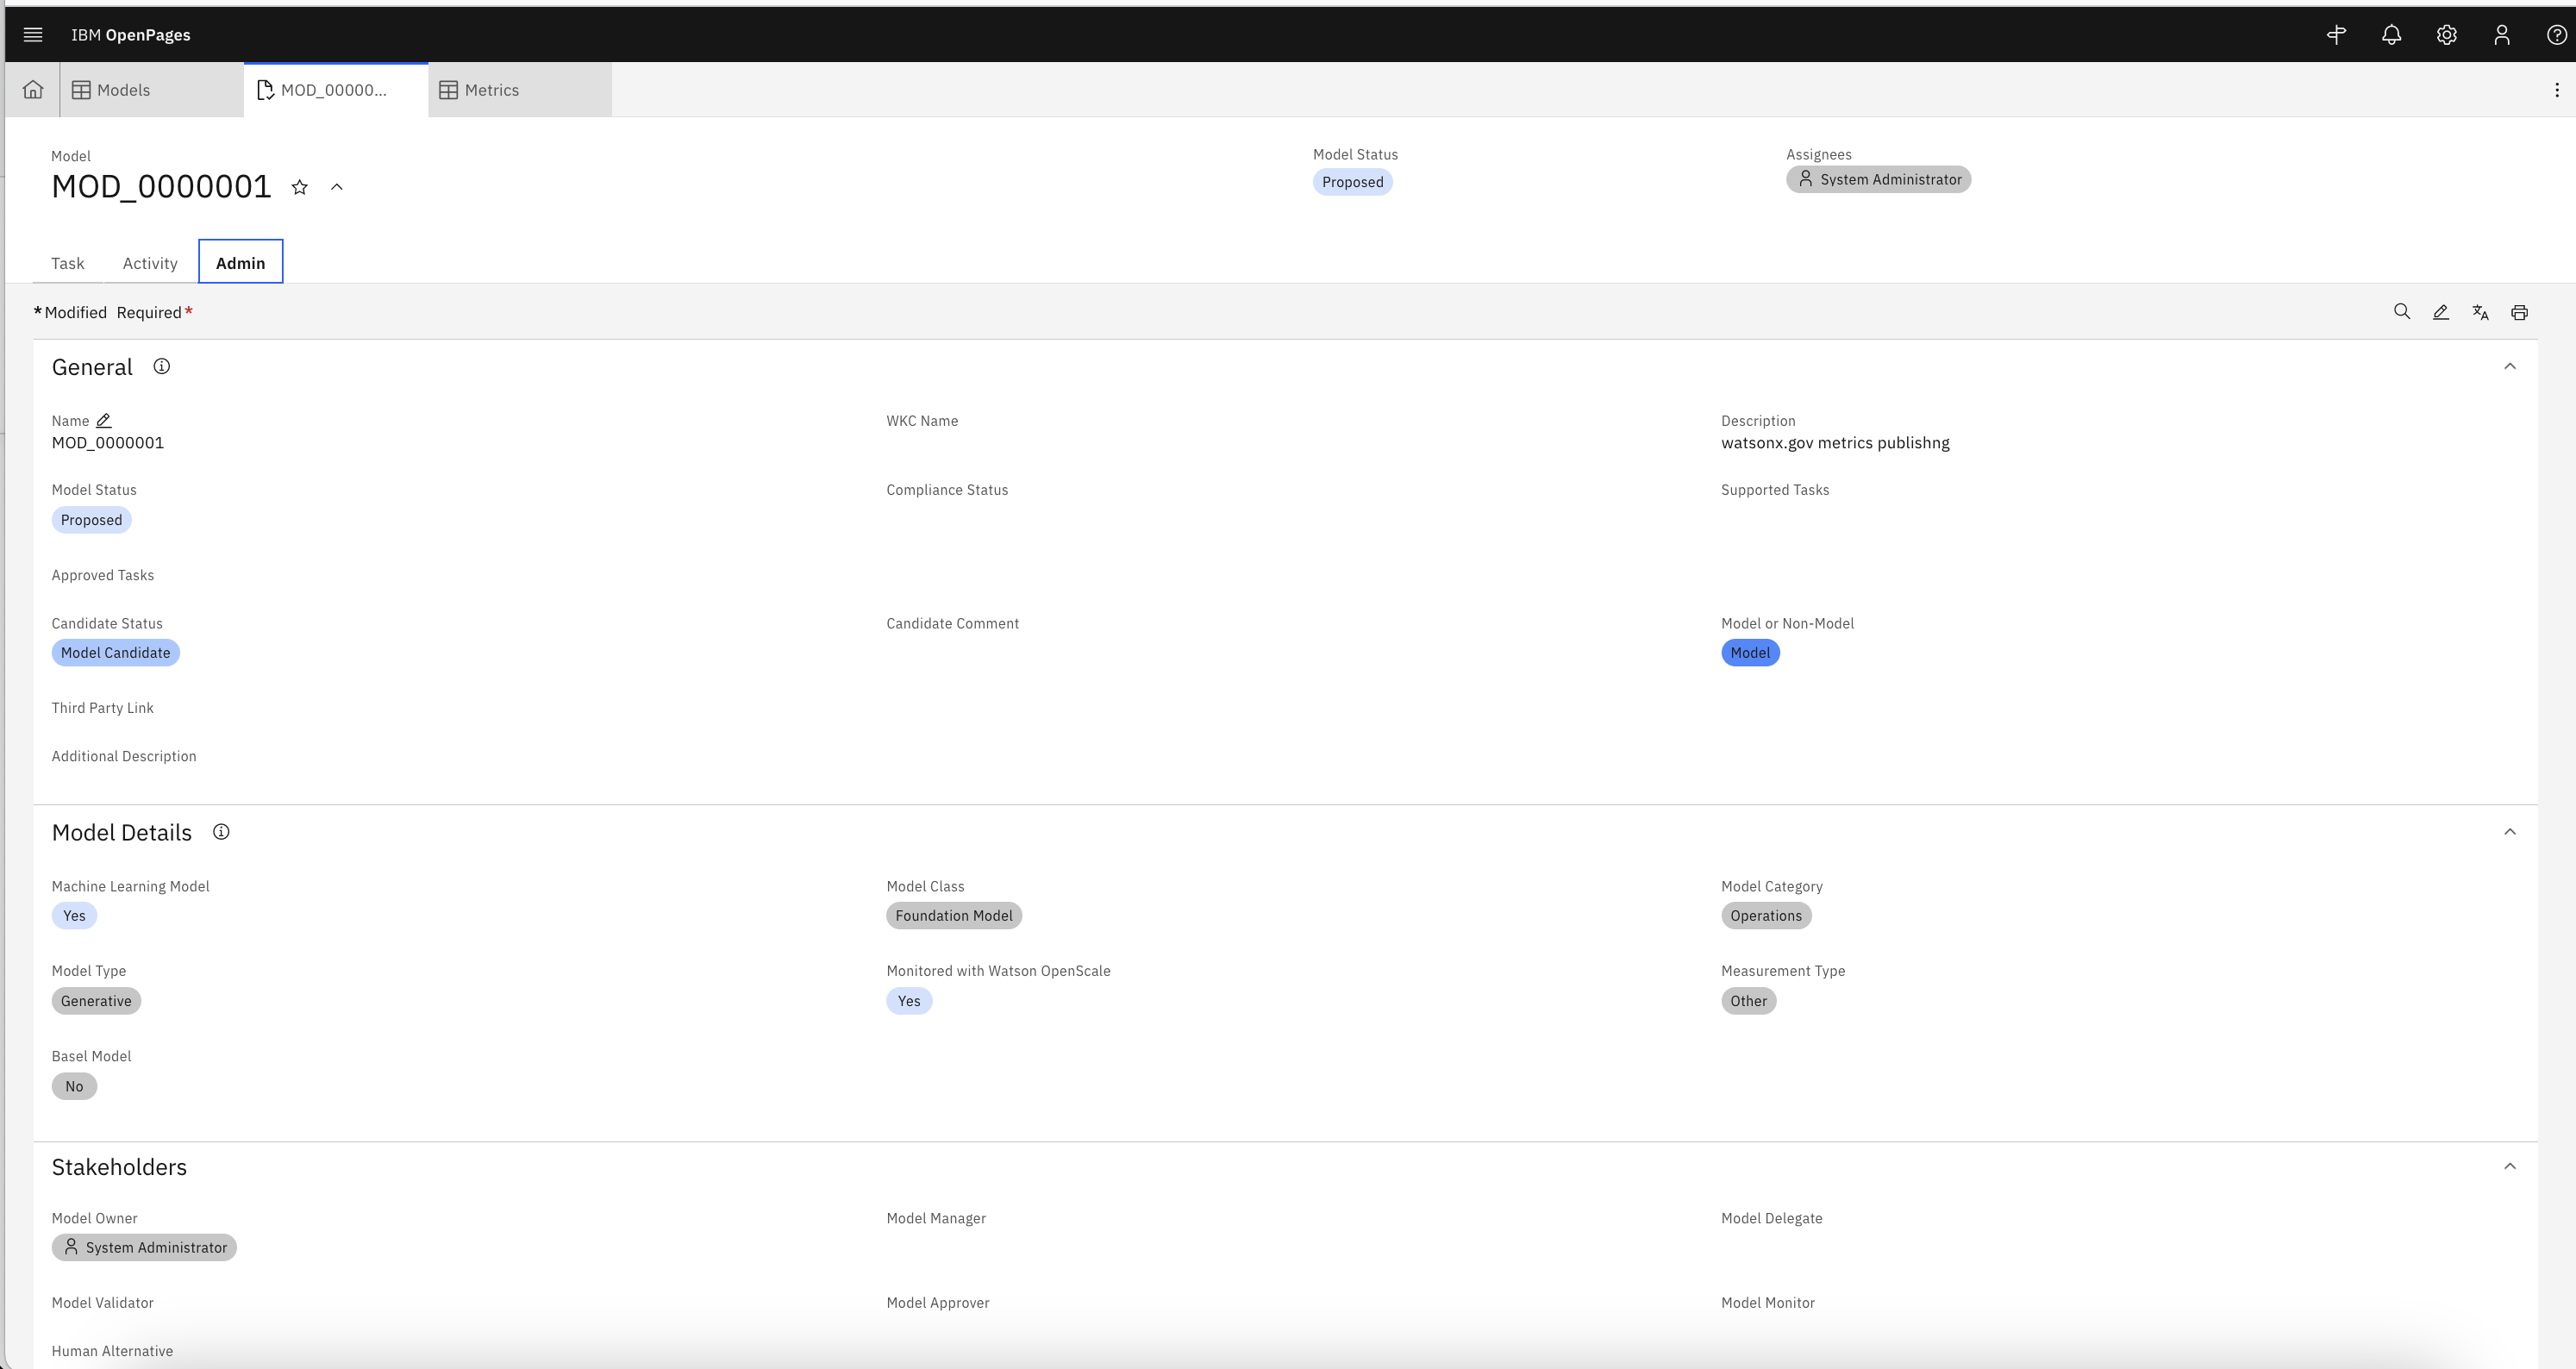

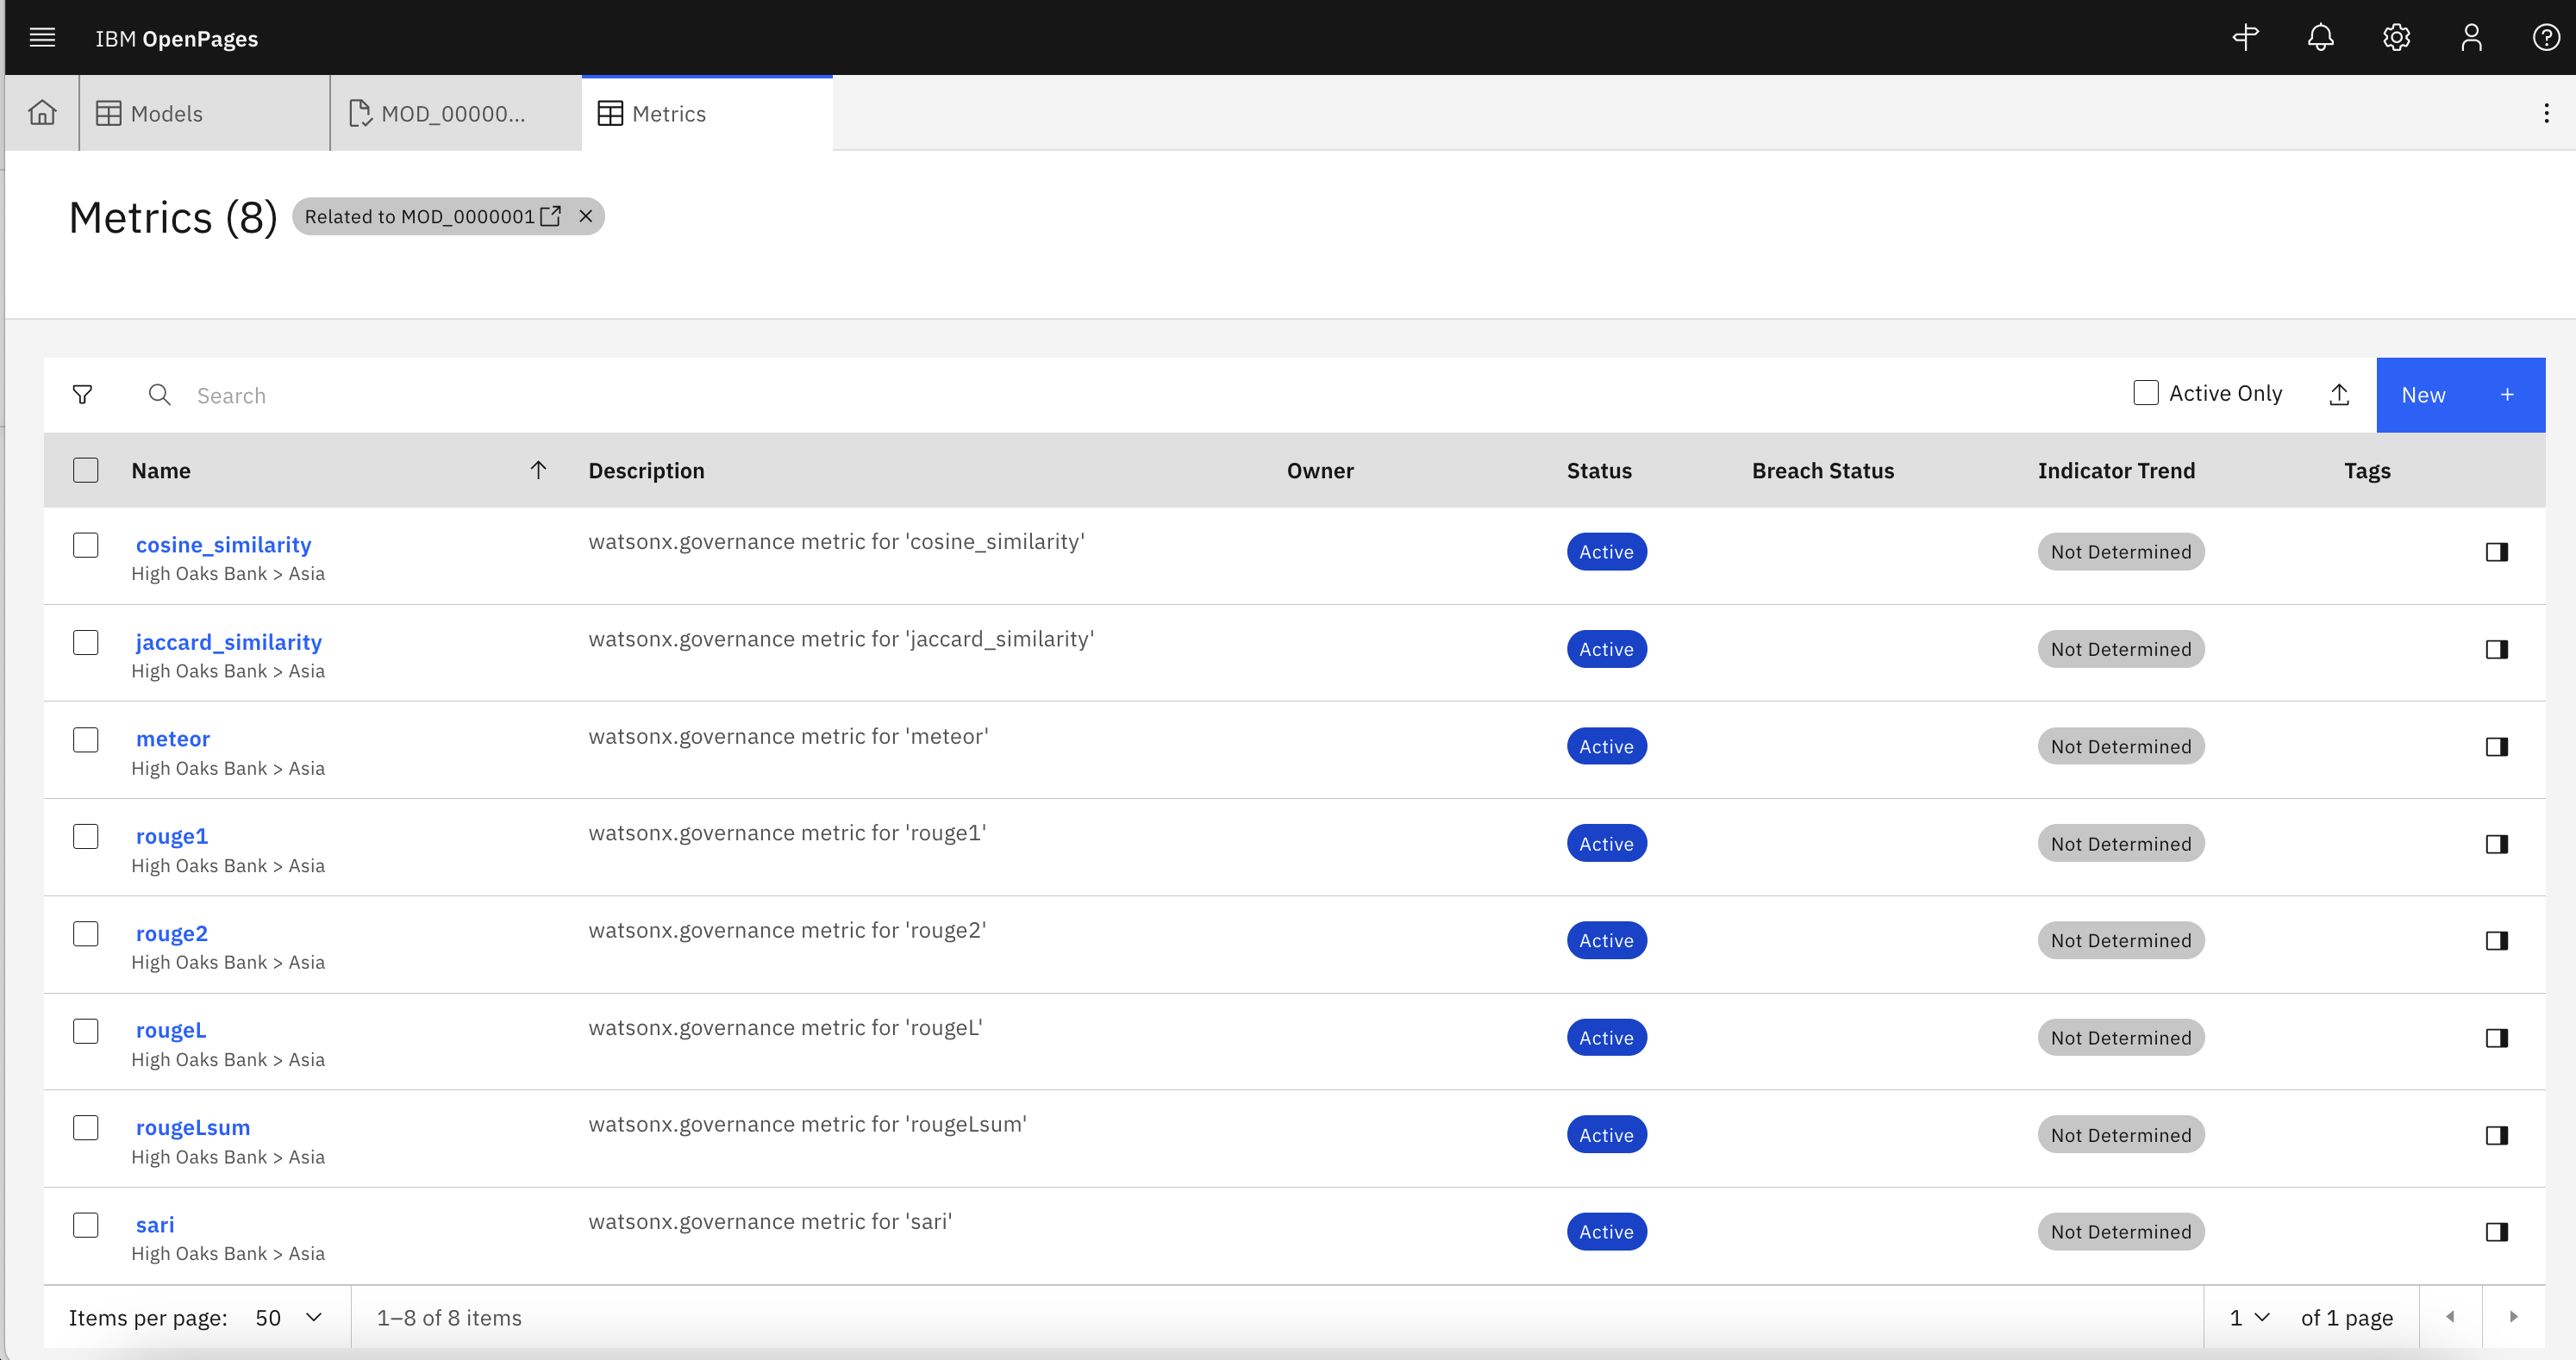

##

Author: ravi.chamarthy@in.ibm.com